In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import epsilon_0 as eps_0, mu_0, c
import jax
from jax import vmap, grad, jit
import jax.numpy as jnp
from jax.ops import index, index_update
jax.config.update("jax_enable_x64", True)

from loader import load_antenna_el_properties
from utils import (central_difference, holoborodko, elementwise_quad as equad,
                   elementwise_dblquad as edblquad)

In [2]:
%config InlineBackend.figure_format = 'retina'


def fig_config(latex=False, nrows=1, ncols=1, scaler=1.0):
    """Configure matplotlib parameters for better visualization style.
    
    Parameters
    ----------
    latex : bool, optional
        If true, LaTeX backend will be used
    nrows : int, optional
        number of figures row-wise
    ncols : int, optional
        number of figures column-wise
    scaler : float, optional
        scaler for each figure
        
    Returns
    -------
    None
    """
    plt.rcParams.update({
        'text.usetex': latex,
        'font.family': 'serif',
        'font.size': 12,
        'figure.figsize': [4.774 * scaler * ncols, 2.950 * scaler * nrows],
        'axes.labelsize': 16,
        'axes.titlesize': 16,
        'grid.linewidth': 0.5,
        'legend.fontsize': 12,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'lines.linewidth': 3.5,
        'lines.markersize': 11,
        'lines.markeredgecolor': 'k',
        'lines.markeredgewidth': 0.5,
    })


def fig_config_reset():
    """Recover matplotlib default parameters.
    
    Parameters
    ----------
    None
    
    Returns
    -------
    None
    """
    plt.rcParams.update(plt.rcParamsDefault)

# 1 Toy example

In [3]:
def f(x):
    return jnp.sin(jnp.sin(2 * x))

def ddf(x):
    return - 4. * (jnp.sin(jnp.sin(2 * x)) * jnp.cos(2 * x) ** 2
                   + jnp.sin(2 * x) * jnp.cos(jnp.sin(2 * x)))


ddf_ad = vmap(grad(grad(f)))


ddf_cd = central_difference(f, order=2, eps=1e-4)

In [4]:
x = jnp.linspace(-1, 1, 21)
y = f(x)
ddy = ddf(x)
ddy_ad = ddf_ad(x)
ddy_cd = ddf_cd(x)

ad_rmse = np.sqrt(np.mean((ddy - ddy_ad) ** 2))
cd_rmse = np.sqrt(np.mean((ddy - ddy_cd) ** 2))

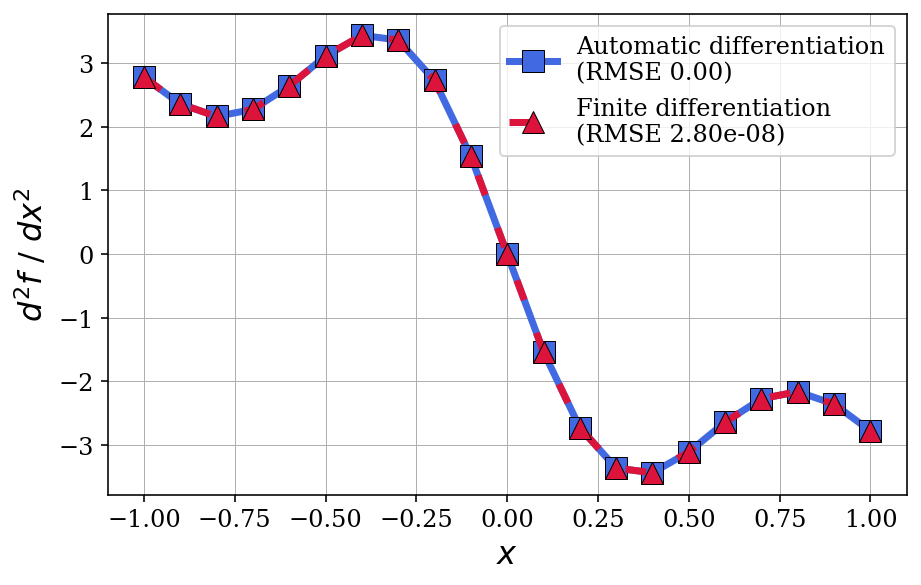

In [5]:
fig_config(scaler=1.5)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, ddy_ad, 's-', color='royalblue', label=f'Automatic differentiation\n(RMSE {ad_rmse:.2f})')
ax.plot(x, ddy_cd, '^--', dashes=(3, 5), color='crimson', label=f'Finite differentiation\n(RMSE {cd_rmse:.2e})')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$d^2f$ / $dx^2$')
ax.legend()
ax.grid()
plt.show()

# 2 Working example

In [6]:
def green(xt, yt, zt, xs, ys, zs, omega):
    k = jnp.sqrt(omega ** 2 * eps_0 * mu_0)
    R = jnp.sqrt((xt - xs) ** 2 + (yt - ys) ** 2 + (zt - zs) ** 2)
    return jnp.exp(-1j * k * R) / R

green = jit(green)

In [7]:
# frequency
f = 10.e9

# antenna electric properties (Poljak 2005)
antenna_data = load_antenna_el_properties(f)
Is = antenna_data.ireal.to_numpy() + antenna_data.iimag.to_numpy() * 1j
dx = antenna_data.x[1] - antenna_data.x[0]
Is_x = holoborodko(Is, dx)

# antenna position -- coordinates
xs = antenna_data.x.to_numpy()
xs = np.asarray(xs)
ys = np.zeros_like(xs)
zs = np.zeros_like(xs)

# effective radiated skin area
target_area = (0.02, 0.02)  # 2 x 2 cm2
A = target_area[0] * target_area[1]
h = -5 / 1000  # distance from the antenna
N = [31, 31, 1]
xt = np.linspace(-target_area[0]/2, target_area[0]/2, N[0]) + xs[-1] / 2
yt = np.linspace(-target_area[1]/2, target_area[1]/2, N[1])
zt = np.array([h])

## 2.1 Central difference approach

In [8]:
def efield_fd(xt, yt, zt, xs, ys, zs, Is, Is_x, frequency):
    omega = 2 * np.pi * frequency
    gamma = 1j * np.sqrt(omega ** 2 * mu_0 * eps_0)
    prefix = 1 / (1j * 4 * np.pi * omega * eps_0)
    g = green(xt, yt, zt, xs, ys, zs, omega)
    g_x = central_difference(green, axis='x', args=(yt, zt, xs, ys, zs, omega), eps=0.001)(xt)
    g_y = central_difference(green, axis='y', args=(xt, zt, xs, ys, zs, omega), eps=0.001)(yt)
    g_z = central_difference(green, axis='z', args=(xt, yt, xs, ys, zs, omega), eps=0.001)(zt)
    Ex = prefix * (- equad(Is_x * g_x, xs, 3) - gamma ** 2 * equad(Is * g, xs, 3))
    Ey = prefix * (equad(Is_x * g_y, xs, 3))
    Ez = prefix * (equad(Is_x * g_z, xs, 3))
    return (Ex, Ey, Ez)


def hfield_fd(xt, yt, zt, xs, ys, zs, Is, frequency):
    omega = 2 * np.pi * frequency
    prefix = 1 / (4 * np.pi)
    g_y = central_difference(green, axis='y', args=(xt, zt, xs, ys, zs, omega))(yt)
    g_z = central_difference(green, axis='z', args=(xt, yt, xs, ys, zs, omega))(zt)
    Hy = prefix * equad(Is * g_z, xs, 3)
    Hz = - prefix * equad(Is * g_y, xs, 3)
    Hx = np.zeros_like(Hz)
    return (Hx, Hy, Hz)

In [9]:
Ex_fd = np.empty((xt.size, yt.size, zt.size), dtype=np.complex128)
Ey_fd = np.empty((xt.size, yt.size, zt.size), dtype=np.complex128)
Ez_fd = np.empty((xt.size, yt.size, zt.size), dtype=np.complex128)
Hx_fd = np.empty((xt.size, yt.size, zt.size), dtype=np.complex128)
Hy_fd = np.empty((xt.size, yt.size, zt.size), dtype=np.complex128)
Hz_fd = np.empty((xt.size, yt.size, zt.size), dtype=np.complex128)
for x_idx, _xt in enumerate(xt):
    for y_idx, _yt in enumerate(yt):
        for z_idx, _zt in enumerate(zt):
            ex, ey, ez = efield_fd(_xt, _yt, _zt, xs, ys, zs, Is, Is_x, f)
            hx, hy, hz = hfield_fd(_xt, _yt, _zt, xs, ys, zs, Is, f)
            Ex_fd[x_idx, y_idx, z_idx], Ey_fd[x_idx, y_idx, z_idx], Ez_fd[x_idx, y_idx, z_idx] = ex.item(), ey.item(), ez.item()
            Hx_fd[x_idx, y_idx, z_idx], Hy_fd[x_idx, y_idx, z_idx], Hz_fd[x_idx, y_idx, z_idx] = hx.item(), hy.item(), hz.item()

In [10]:
I0m_fd = np.sqrt(np.power(Ex_fd * Hy_fd.conj(), 2)) 
I0_fd = np.real(I0m_fd)
IPD_fd = 1 / (2 * A) * edblquad(I0_fd, xt, yt, 31)

## 2.2 Automatic differentiation approach

In [11]:
# conversion
xs = jnp.asarray(xs)
ys = jnp.asarray(ys)
zs = jnp.asarray(zs)
xt = jnp.asarray(xt)
yt = jnp.asarray(yt)
zt = jnp.asarray(zt)
Is = jnp.asarray(Is)
Is_x = jnp.asarray(Is_x)

In [12]:
green_grad = jit(vmap(
    grad(green, argnums=(0, 1, 2), holomorphic=True),
    in_axes=(None, None, None, 0, 0, 0, None)))


def efield_ad(xt, yt, zt, xs, ys, zs, Is, Is_x, frequency):
    omega = 2 * jnp.pi * frequency
    gamma = 1j * jnp.sqrt(omega ** 2 * mu_0 * eps_0)
    prefix = 1 / (1j * 4 * jnp.pi * omega * eps_0)
    g = green(xt, yt, zt, xs, ys, zs, omega)
    g_x, g_y, g_z = green_grad(xt + 0j, yt + 0j, zt + 0j, xs, ys, zs, omega)
    Ex = prefix * (- equad(Is_x * g_x, xs, 3) - gamma ** 2 * equad(Is * g, xs, 3))
    Ey = prefix * (equad(Is_x * g_y, xs, 3))
    Ez = prefix * (equad(Is_x * g_z, xs, 3))
    return (Ex, Ey, Ez)


def hfield_ad(xt, yt, zt, xs, ys, zs, Is, frequency):
    omega = 2 * jnp.pi * frequency
    prefix = 1 / (4 * jnp.pi)
    g_x, g_y, g_z = green_grad(xt + 0j, yt + 0j, zt + 0j, xs, ys, zs, omega)
    Hy = prefix * equad(Is * g_z, xs, 3)
    Hz = - prefix * equad(Is * g_y, xs, 3)
    Hx = np.zeros_like(Hz)
    return (Hx, Hy, Hz)

In [13]:
Ex_ad = np.empty((xt.size, yt.size, zt.size), dtype=np.complex128)
Ey_ad = np.empty((xt.size, yt.size, zt.size), dtype=np.complex128)
Ez_ad = np.empty((xt.size, yt.size, zt.size), dtype=np.complex128)
Hx_ad = np.empty((xt.size, yt.size, zt.size), dtype=np.complex128)
Hy_ad = np.empty((xt.size, yt.size, zt.size), dtype=np.complex128)
Hz_ad = np.empty((xt.size, yt.size, zt.size), dtype=np.complex128)
for x_idx, _xt in enumerate(xt):
    for y_idx, _yt in enumerate(yt):
        for z_idx, _zt in enumerate(zt):
            ex, ey, ez = efield_ad(_xt, _yt, _zt, xs, ys, zs, Is, Is_x, f)
            hx, hy, hz = hfield_ad(_xt, _yt, _zt, xs, ys, zs, Is, f)
            Ex_ad[x_idx, y_idx, z_idx], Ey_ad[x_idx, y_idx, z_idx], Ez_ad[x_idx, y_idx, z_idx] = ex.item(), ey.item(), ez.item()
            Hx_ad[x_idx, y_idx, z_idx], Hy_ad[x_idx, y_idx, z_idx], Hz_ad[x_idx, y_idx, z_idx] = hx.item(), hy.item(), hz.item()

In [14]:
I0m_ad = np.sqrt(np.power(Ex_ad * Hy_ad.conj(), 2)) 
I0_ad = np.real(I0m_ad)
IPD_ad = 1 / (2 * A) * edblquad(I0_ad, xt, yt, 31)

## 2.3 Evaluation

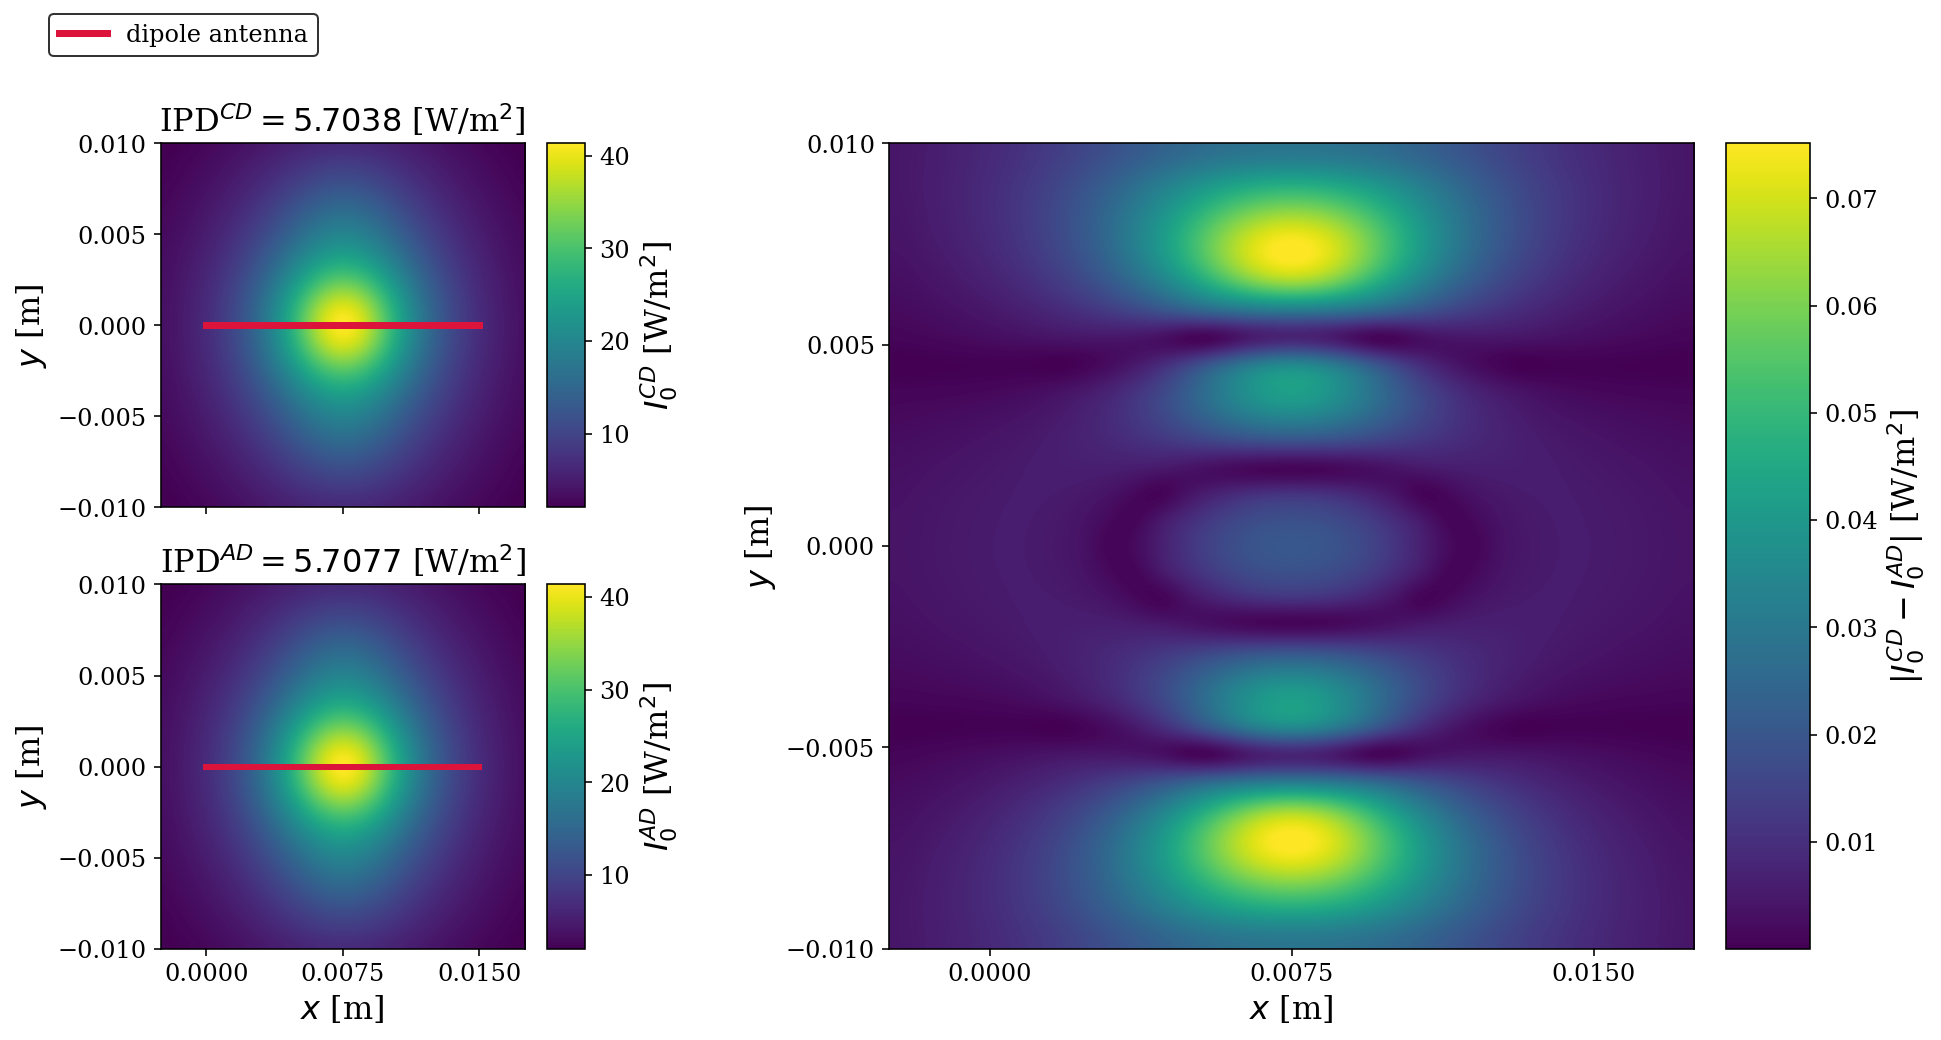

In [17]:
extent = (xt.min(), xt.max(), yt.min(), yt.max())
difference = np.abs(I0_fd - I0_ad)

fig = plt.figure(constrained_layout=True, figsize=(13.5, 6.5))
gs = fig.add_gridspec(nrows=2, ncols=3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax3 = fig.add_subplot(gs[0:, 1:])

cs1 = ax1.imshow(I0_fd, origin='lower', interpolation='spline36', extent=extent)
cbar1 = fig.colorbar(cs1, ax=ax1)
cbar1.ax.set_ylabel('$I_0^{CD}$ [W/m$^2$]')
ax1.plot(xs, ys, '-', color='crimson', label='dipole antenna')
ax1.set_title(f'IPD$^{{CD}} = {IPD_fd.item():.4f}$ [W/m$^2$]')
ax1.set_xticks([0.0, 0.0075, 0.015])
ax1.set_yticks([-0.01, -0.005, 0.0, 0.005, 0.01])
ax1.set_ylabel('$y$ [m]')

cs2 = ax2.imshow(I0_ad, origin='lower', interpolation='spline36', extent=extent)
cbar2 = fig.colorbar(cs2, ax=ax2)
cbar2.ax.set_ylabel('$I_0^{AD}$ [W/m$^2$]')
ax2.plot(xs, ys, '-', color='crimson', linewidth=3)
ax2.set_title(f'IPD$^{{AD}} = {IPD_ad.item():.4f}$ [W/m$^2$]')
ax2.set_xticks([0.0, 0.0075, 0.015])
ax2.set_yticks([-0.01, -0.005, 0.0, 0.005, 0.01])
ax2.set_xlabel('$x$ [m]')
ax2.set_ylabel('$y$ [m]')

cs3 = ax3.imshow(difference, origin='lower', interpolation='spline36', extent=extent)
cbar3 = fig.colorbar(cs3, ax=ax3)
cbar3.ax.set_ylabel('$|I_0^{CD} - I_0^{AD}|$ [W/m$^2$]')
ax3.set_xticks([0.0, 0.0075, 0.015])
ax3.set_yticks([-0.01, -0.005, 0.0, 0.005, 0.01])
ax3.set_xlabel('$x$ [m]')
ax3.set_ylabel('$y$ [m]')

fig.legend(bbox_to_anchor=(0.175, 1.1), frameon=True, edgecolor='k')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.show()